In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import os

import xgboost
from sklearn.model_selection import train_test_split

import slice_finding as sf
from importlib import reload
reload(sf);

In [2]:
df = pd.read_csv("example_data/adult.csv")
df.head()
print (len(df))

48842


In [3]:
def _assign_bin_values(col_data, bin_spec):
    lower = bin_spec.get("min", np.quantile(col_data, 0.25))
    upper = bin_spec.get("max", np.quantile(col_data, 0.75))
    assert lower < upper, (lower, upper)
    return np.digitize(col_data, [lower, upper])

def extreme_value_binning(col_name, col_data, gender_data):
    if col_name not in NORMAL_RANGES:
        return np.digitize(col_data, np.quantile(col_data, [0.25, 0.75]))
    norm_range = NORMAL_RANGES[col_name]
    if "female" in norm_range:
        return np.where(gender_data, 
                        _assign_bin_values(col_data, norm_range["female"]),
                        _assign_bin_values(col_data, norm_range["male"]))
    return _assign_bin_values(col_data, norm_range)

def discretize_data(df, spec):
    discrete_columns = {}
    for col, col_spec in spec.items():
        if callable(col_spec["method"]):
            discrete_columns[col] = col_spec["method"](df[col], col)
        elif col_spec["method"] == "keep":
            discrete_columns[col] = df[col].values
        elif col_spec["method"] == "bin":
            discrete_columns[col] = np.digitize(df[col], col_spec["bins"]) - 1
        elif col_spec["method"] == "unique":
            unique_vals = sorted(df[col].unique().tolist())
            discrete_columns[col] = df[col].apply(lambda v: unique_vals.index(v))
    return pd.DataFrame(discrete_columns, index=df.index)

discrete_df = discretize_data(df, {
    'age': { "method": "bin", "bins": [0, 25, 45, 65] }, 
    'workclass': { "method": "unique" }, 
    'education': { "method": "unique" }, 
    'marital-status': { "method": "unique" }, 
    'occupation': { "method": "unique" }, 
    'relationship': { "method": "unique" }, 
    'race': { "method": "unique" }, 
    'gender': { "method": "unique" },   
    'capital-gain': { "method": "bin", "bins": [0, 1] }, 
    'capital-loss': { "method": "bin", "bins": [0, 1] }, 
    'hours-per-week': { "method": "bin", "bins": [0, 39] }, 
    'native-country': { "method": lambda x, c: x != 'United-States' },
})

In [4]:
df_prepped = df.drop(columns=['fnlwgt', 'educational-num'])

X = df_prepped.drop(columns=['income'])
y = df_prepped['income'] == '>50K'

X_continous  = X[['age', 'capital-gain', 'capital-loss', 'hours-per-week']]
print (X_continous.head())
X_categorical = X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race',
                   'gender', 'native-country']]
print (X_categorical.head())
X_encoded = pd.get_dummies(X_categorical)
print ("encoded:")
print ("")
print (X_encoded)

X = pd.concat([X_continous, X_encoded], axis=1)

   age  capital-gain  capital-loss  hours-per-week
0   25             0             0              40
1   38             0             0              50
2   28             0             0              40
3   44          7688             0              40
4   18             0             0              30
   workclass     education      marital-status         occupation  \
0    Private          11th       Never-married  Machine-op-inspct   
1    Private       HS-grad  Married-civ-spouse    Farming-fishing   
2  Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3    Private  Some-college  Married-civ-spouse  Machine-op-inspct   
4          ?  Some-college       Never-married                  ?   

  relationship   race  gender native-country  
0    Own-child  Black    Male  United-States  
1      Husband  White    Male  United-States  
2      Husband  White    Male  United-States  
3      Husband  Black    Male  United-States  
4    Own-child  White  Female  United-States

In [5]:
import os

if not os.path.exists("example_data/adult_model.json"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)

    print(model.score(X_test, y_test))

    model.save_model("example_data/adult_model.json")
else:
    model = xgboost.XGBClassifier()
    model.load_model("example_data/adult_model.json")

In [6]:
outcome_bins = 10
model_preds = model.predict(X)
discrete_outcomes = model_preds == y # df["income"] == ">50K"
print(discrete_outcomes.mean())

# Set up score functions
score_functions = {
    "error_rate": sf.OutcomeRateScore(1 - discrete_outcomes.values),
    "group_size": sf.SliceSizeScore(0.5, spread=0.25),
}

# the slices must contain at least this fraction of the dataset.
# a higher value would mean that fewer slices are eligible, and
# also that sampling is more likely to work well
min_items = int(len(discrete_df) * 0.001)

num_slices_to_return = 50

max_features = 3

0.8846484582940911


## Run recursive implementation

In [7]:
results = sf.find_slices(
    discrete_df.astype(int),
    score_functions,
    min_items=min_items, 
    n_slices=num_slices_to_return,
    algorithm='recursive',
    max_features=max_features,
)

Slice finding for 1 feature(s)
Done for:  1 , scored 72 slices
Slice finding for 2 feature(s)
Done for:  2 , scored 2238 slices
Slice finding for 3 feature(s)
Done for:  3 , scored 39716 slices


In [8]:
results

[<Slice: education: 11, occupation: 13, relationship: 0; scores: error_rate: 3.3474738237311543, group_size: 0.1375880682792105>,
 <Slice: education: 11, marital-status: 2, occupation: 13; scores: error_rate: 3.186079492364939, group_size: 0.13794750397666652>,
 <Slice: age: 2, education: 8, occupation: 3; scores: error_rate: 3.0386540143273737, group_size: 0.13749831889694492>,
 <Slice: workclass: 1, marital-status: 2, occupation: 3; scores: error_rate: 3.0273051988455775, group_size: 0.13673721655769436>,
 <Slice: education: 9, occupation: 3, relationship: 0; scores: error_rate: 2.971100589778161, group_size: 0.14011887067304177>,
 <Slice: education: 7, occupation: 13, relationship: 0; scores: error_rate: 2.9474946539698457, group_size: 0.13644704190628115>,
 <Slice: occupation: 13, relationship: 0, hours-per-week: 0; scores: error_rate: 2.9413024565225907, group_size: 0.1365809113082728>,
 <Slice: workclass: 1, occupation: 3, relationship: 0; scores: error_rate: 2.936308748903836, g

## Run sampling implementation

In [34]:
def get_sampling_avg_recall_random(number_of_samples, number_of_iterations):
    results_sampling_unranked_random = []
    
    for i in range(number_of_iterations):
        tmp_results_sampling_unranked_random = sf.find_slices(
            discrete_df.astype(int),
            score_functions,
            algorithm='sampling',
            source_mask=None,
            min_items=min_items,
            num_samples=number_of_samples,
            num_candidates=None,
            max_features=max_features
        )
        tmp_results_sampling_random = tmp_results_sampling_unranked_random.rank({fn_name: 1.0 for fn_name in score_functions},
                                                          n_slices=num_slices_to_return, 
                                                          similarity_threshold=1.0)
        random_sampling_recall = len(set(tmp_results_sampling_random) & set(results)) / len(results)

        results_sampling_unranked_random.append(random_sampling_recall)
    
    print (results_sampling_unranked_random)
    return sum(results_sampling_unranked_random) / len(results_sampling_unranked_random)

def get_sampling_avg_recall_selective(number_of_samples, number_of_iterations):
    results_sampling_unranked_selective = []
    
    for i in range(number_of_iterations):
        tmp_results_sampling_unranked = sf.find_slices(
            discrete_df.astype(int),
            score_functions,
            algorithm='sampling',
            source_mask= (discrete_outcomes == 0),
            min_items=min_items,
            num_samples=number_of_samples,
            num_candidates=None,
            max_features=max_features
        )
        tmp_results_sampling_selective = tmp_results_sampling_unranked.rank({fn_name: 1.0 for fn_name in score_functions},
                                                          n_slices=num_slices_to_return, 
                                                          similarity_threshold=1.0)
        
        selective_sampling_recall = len(set(tmp_results_sampling_selective) & set(results)) / len(results)

        results_sampling_unranked_selective.append(selective_sampling_recall)
    
    print (results_sampling_unranked_selective)
    return sum(results_sampling_unranked_selective) / len(results_sampling_unranked_selective)


In [43]:
def get_recall_random_samplings (sample_count_list, number_of_iterations):
    recall_random_samplings = {}
    for number_of_samples in sample_count_list:
        recall_random_sampling = get_sampling_avg_recall_random(number_of_samples, number_of_iterations)
        recall_random_samplings[number_of_samples] = recall_random_sampling
    return recall_random_samplings
    
def get_recall_selective_samplings (sample_count_list, number_of_iterations):
    recall_random_samplings = {}
    for number_of_samples in sample_count_list:
        recall_random_sampling = get_sampling_avg_recall_selective(number_of_samples, number_of_iterations)
        recall_random_samplings[number_of_samples] = recall_random_sampling
    return recall_random_samplings

In [61]:
number_of_iterations = 50

sample_count_list = [1, 5, 10, 50, 100]

recall_random_samplings = get_recall_random_samplings(sample_count_list, number_of_iterations)
recall_selective_samplings = get_recall_selective_samplings(sample_count_list, number_of_iterations)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.52it/s]


[0.38, 0.0, 0.38, 0.38, 0.0, 0.14, 0.26, 0.0, 0.38, 0.08, 0.38, 0.32, 0.0, 0.38, 0.0, 0.0, 0.0, 0.14, 0.0, 0.38, 0.38, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38, 0.38, 0.38, 0.22, 0.38, 0.38, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.4, 0.38, 0.38, 0.44, 0.0, 0.0, 0.36, 0.38, 0.08, 0.0]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


[0.44, 0.42, 0.38, 0.2, 0.42, 0.4, 0.4, 0.38, 0.38, 0.4, 0.38, 0.0, 0.38, 0.38, 0.4, 0.4, 0.42, 0.38, 0.0, 0.2, 0.38, 0.4, 0.42, 0.36, 0.4, 0.2, 0.06, 0.42, 0.44, 0.4, 0.0, 0.22, 0.2, 0.48, 0.22, 0.4, 0.0, 0.4, 0.24, 0.0, 0.34, 0.0, 0.22, 0.38, 0.4, 0.38, 0.38, 0.4, 0.38, 0.4]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.78it/s]


[0.38, 0.38, 0.46, 0.38, 0.4, 0.44, 0.42, 0.48, 0.42, 0.22, 0.38, 0.38, 0.42, 0.38, 0.4, 0.4, 0.48, 0.46, 0.38, 0.38, 0.38, 0.42, 0.38, 0.38, 0.5, 0.44, 0.4, 0.4, 0.4, 0.4, 0.38, 0.38, 0.4, 0.4, 0.38, 0.4, 0.38, 0.4, 0.4, 0.38, 0.52, 0.48, 0.5, 0.38, 0.4, 0.4, 0.4, 0.4, 0.38, 0.4]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.05it/s]


[0.58, 0.44, 0.42, 0.62, 0.58, 0.52, 0.68, 0.46, 0.44, 0.44, 0.4, 0.52, 0.66, 0.5, 0.58, 0.62, 0.4, 0.44, 0.42, 0.46, 0.42, 0.64, 0.58, 0.44, 0.5, 0.56, 0.46, 0.42, 0.48, 0.6, 0.54, 0.56, 0.5, 0.52, 0.4, 0.62, 0.58, 0.48, 0.44, 0.6, 0.66, 0.5, 0.54, 0.4, 0.48, 0.54, 0.58, 0.6, 0.58, 0.5]


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 32.67it/s]


[0.54, 0.64, 0.62, 0.54, 0.52, 0.58, 0.54, 0.66, 0.64, 0.58, 0.6, 0.48, 0.6, 0.44, 0.54, 0.62, 0.54, 0.52, 0.6, 0.62, 0.66, 0.68, 0.62, 0.44, 0.5, 0.46, 0.64, 0.48, 0.6, 0.58, 0.6, 0.72, 0.52, 0.54, 0.5, 0.52, 0.46, 0.56, 0.54, 0.46, 0.5, 0.56, 0.48, 0.54, 0.64, 0.64, 0.5, 0.5, 0.42, 0.56]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


[0.38, 0.38, 0.38, 0.38, 0.38, 0.34, 0.38, 0.38, 0.0, 0.0, 0.42, 0.38, 0.4, 0.0, 0.18, 0.38, 0.38, 0.38, 0.38, 0.18, 0.38, 0.0, 0.38, 0.38, 0.0, 0.16, 0.48, 0.38, 0.38, 0.26, 0.38, 0.0, 0.28, 0.38, 0.38, 0.38, 0.38, 0.26, 0.18, 0.38, 0.38, 0.0, 0.38, 0.14, 0.38, 0.42, 0.0, 0.34, 0.14, 0.0]


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.54it/s]


[0.48, 0.44, 0.4, 0.4, 0.38, 0.44, 0.4, 0.44, 0.4, 0.4, 0.54, 0.38, 0.4, 0.4, 0.5, 0.38, 0.38, 0.38, 0.38, 0.44, 0.48, 0.46, 0.38, 0.42, 0.4, 0.44, 0.38, 0.54, 0.38, 0.42, 0.58, 0.4, 0.44, 0.48, 0.42, 0.38, 0.58, 0.38, 0.38, 0.44, 0.4, 0.42, 0.4, 0.42, 0.4, 0.4, 0.4, 0.54, 0.38, 0.56]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.23it/s]


[0.52, 0.54, 0.56, 0.44, 0.4, 0.44, 0.56, 0.5, 0.38, 0.38, 0.56, 0.4, 0.56, 0.48, 0.44, 0.42, 0.4, 0.44, 0.4, 0.4, 0.56, 0.48, 0.4, 0.4, 0.48, 0.48, 0.46, 0.42, 0.4, 0.56, 0.4, 0.44, 0.46, 0.48, 0.44, 0.4, 0.56, 0.54, 0.42, 0.42, 0.44, 0.42, 0.48, 0.4, 0.44, 0.54, 0.4, 0.44, 0.58, 0.38]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 26.15it/s]


[0.52, 0.66, 0.48, 0.56, 0.58, 0.52, 0.52, 0.56, 0.68, 0.64, 0.66, 0.54, 0.7, 0.6, 0.68, 0.6, 0.52, 0.48, 0.56, 0.6, 0.6, 0.58, 0.6, 0.56, 0.64, 0.6, 0.64, 0.6, 0.6, 0.62, 0.48, 0.48, 0.62, 0.74, 0.7, 0.6, 0.58, 0.58, 0.58, 0.64, 0.64, 0.58, 0.6, 0.62, 0.46, 0.7, 0.58, 0.66, 0.62, 0.58]


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 44.10it/s]


[0.66, 0.62, 0.66, 0.74, 0.74, 0.76, 0.7, 0.68, 0.76, 0.7, 0.7, 0.64, 0.72, 0.7, 0.76, 0.66, 0.72, 0.74, 0.8, 0.74, 0.74, 0.7, 0.82, 0.6, 0.66, 0.72, 0.76, 0.76, 0.62, 0.76, 0.8, 0.68, 0.66, 0.74, 0.58, 0.58, 0.74, 0.76, 0.62, 0.6, 0.7, 0.7, 0.62, 0.74, 0.68, 0.72, 0.68, 0.72, 0.74, 0.64]


In [62]:
print (np.sum(discrete_outcomes == 0))

print (recall_random_samplings)
print (recall_selective_samplings)

5634
{1: 0.1784, 5: 0.31360000000000016, 10: 0.406, 50: 0.518, 100: 0.5568}
{1: 0.2812000000000001, 5: 0.42919999999999997, 10: 0.45880000000000015, 50: 0.5948, 100: 0.7008000000000001}


In [63]:
# # Recall
# print ("Random Sampling Recall:", recall_random_sampling)
# print ("Selective Sampling Recall:", recall_selective_sampling)

In [64]:
# len(results_sampling_unranked.results)

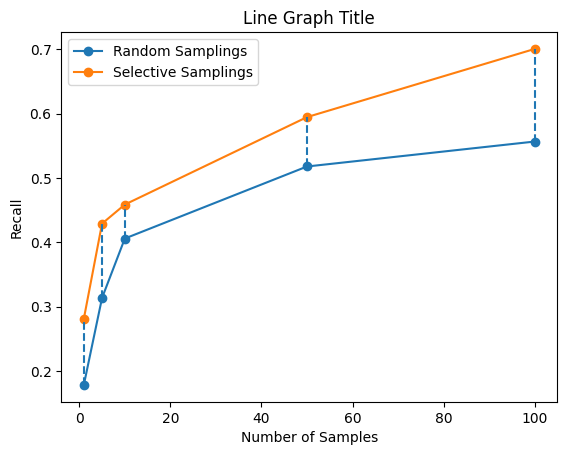

In [65]:
import matplotlib.pylab as plt

lists = sorted(recall_random_samplings.items()) # sorted by key, return a list of tuples
lists1 = sorted(recall_selective_samplings.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
x1, y1 = zip(*lists1)

plt.plot(x, y, marker='o', label="Random Samplings")
plt.plot(x1, y1, marker='o', label="Selective Samplings")
plt.xlabel("Number of Samples")
plt.ylabel("Recall")
plt.title("Line Graph Title")
plt.legend()

# iterate through x values and draw vertical lines where x values match
for i in range(len(x)):
    if x[i] in x1:
        index = x1.index(x[i])
        plt.vlines(x=x[i], ymin=y[i], ymax=y1[index], linestyles="dashed")
        
plt.show()